In [1]:
# Class to Create and Forecast time series using Amazon Chronos

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import json
import torch
import random
import transformers
from statsmodels.tsa.seasonal import seasonal_decompose
from chronos import ChronosPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from gluonts.dataset.common import ListDataset
from tqdm.auto import tqdm


class ChronosForecaster:

    def __init__(self) -> None:
        transformers.set_seed(42)
        self.limit_pred_len = True
        pass

    @staticmethod
    def is_gpu():
        return torch.cuda.is_available()
    
    def get_series_decomposition(self, series, model='additive', period=12):
        result = seasonal_decompose(series, model=model, period=period)
        result.plot()
        return result

    def calculate_metrics(self, predicted, ground_truth):
        mae = mean_absolute_error(ground_truth, predicted)
        mse = mean_squared_error(ground_truth, predicted)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(ground_truth, predicted)
        r_squared = r2_score(ground_truth, predicted)

        return {
            'MAE': round(mae,2),
            'MSE': round(mse,2),
            'RMSE': round(rmse,2),
            'MAPE': round(mape,2),
            'R-squared': round(r_squared,2),
        }
    
    # Split by percentage
    def split_train_test(self, df, test_size=0.2, limit_pred_length=True):
        self.df = df
        _, _, self.y_train, self.y_test = train_test_split(df, df, test_size=test_size, random_state=42, shuffle=False)
        clipped = False
        self.limit_pred_len = limit_pred_length
        if len(self.y_test) > 64 and self.limit_pred_len:
            print(f"[!] Test array size is {len(self.y_test)} which is > 64!")
            print("Clipping test data size to first 64 samples for acceptable accuracy")
            self.y_test = self.y_test[:64]
            self.y_train = self.y_train[:-len(self.y_test)]
            clipped = True
        else:
            print('[!] WARNING: limit_pred_length is disabled! Far future prediction will have low accuracy!')
        return self.y_train, self.y_test, clipped
    
    # Split by number of samples to be predicted
    def split_train_test_by_sample_size(self, df, target_column, test_sample_size=24):
        self.df = df
        self.y_test:pd.DataFrame = df.iloc[-test_sample_size:][target_column]
        self.y_train:pd.DataFrame = df.iloc[:len(df)-test_sample_size][target_column]
        self.limit_pred_len = False
        return self.y_train, self.y_test

    def predict(self, model_name="amazon/chronos-t5-small", num_samples=20, temp=1, top_k=50, top_p=1, debug=True):
        device = "cuda"
        self.pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16
        )
        try:
            context = torch.tensor(self.y_train)
        except ValueError:
            context = torch.tensor(self.y_train.astype(float).values)
        prediction_length = len(self.y_test)
        if debug:
            print(f"Using {device}\nContext length = {len(self.y_train)}\nForecast length = {prediction_length}\nSample size = {num_samples}")
        self.forecast = self.pipeline.predict(
            context,
            prediction_length,
            num_samples=num_samples,
            temperature=temp,
            top_k=int(top_k),
            top_p=top_p,
            limit_prediction_length=self.limit_pred_len
        )

        # self.forecast_index = range(len(self.y_train), len(self.y_train) + prediction_length)
        self.forecast_index = range(self.y_test.index[0], self.y_test.index[-1] + 1)
        self.low, self.median, self.high = np.quantile(self.forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
        # self.median = self.forecast[0].numpy().mean(axis=0)           # Mean instead of median
        self.metrics = self.calculate_metrics(self.median, self.y_test)
        self.params = json.dumps({
                "model": model_name,
                "top_p": top_p,
                "top_k": top_k,
                "tempearature": temp,
                "num_samples": num_samples,
                "context_length": len(self.y_train),
                "prediction_length": prediction_length
            },
            indent=2)

        return (self.forecast, self.metrics, self.median)
    
    def plot_forecast(self, series:pd.Series):
        plt.figure(figsize=(8, 4))
        plt.plot(series, color="royalblue", label="Historical Data")
        plt.plot(self.y_test, color="green", label="Ground Truth")
        plt.plot(self.forecast_index, self.median, color="tomato", label="Median Forecast")
        plt.fill_between(self.forecast_index, self.low, self.high, color="tomato", alpha=0.3, label="80% Prediction Interval")
        plt.title('CHRONOS Forecasting')
        plt.figtext(1, 0.55, "Metrics:\n" + json.dumps(self.metrics, indent=2))
        plt.figtext(1, 0.1, "Params:\n" + self.params)
        plt.legend()
        plt.grid()
        return plt

    # Run tunning experiments for model param optimisation
    def tune_model(self, num_iterations, series, metric_name='MSE'):
        list_metrics = []

        for i in range(num_iterations):
            model_name = random.choice(["amazon/chronos-t5-small"])
            top_p = random.randint(10, 100)
            top_k = round(random.randrange(1,10,1)/10,1)
            temp = round(random.randrange(1,10,1)/10,1)
            num_samples = random.randint(9,51)

            print(f'Running iteration {i} -> top_p = {top_p}, top_k = {top_k}, temp = {temp}, num_samples = {num_samples}')
            
            _, result, _ = self.predict(
                model_name=model_name,
                num_samples=num_samples,
                temp=temp,
                top_k=top_k,
                top_p=top_p,
                debug=False
            )

            plot = self.plot_forecast(series)
            plot.savefig(f'results/{series.name}-{i}.png', bbox_inches='tight')
            plot.close()

            result['filename'] = f'results/{series.name}-{i}.png'

            list_metrics.append(result | json.loads(self.params))

        return pd.DataFrame(sorted(list_metrics, key=lambda x: x[metric_name]))

/home/yogi/miniconda3/envs/chronos-zero-shot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running with idx = 5350
Using cuda
Context length = 1500
Forecast length = 64
Sample size = 3
token=  tensor([[2132, 2128, 2127, 2126, 2128, 2127, 2126, 2126, 2125, 2125, 2125, 2126,
         2125, 2126, 2126, 2125, 2124, 2125, 2124, 2121, 2119, 2119, 2122, 2121,
         2122, 2124, 2124, 2126, 2126, 2126, 2126, 2128, 2129, 2129, 2126, 2126,
         2126, 2126, 2126, 2126, 2127, 2126, 2127, 2127, 2127, 2127, 2128, 2131,
         2130, 2133, 2131, 2131, 2130, 2128, 2126, 2127, 2127, 2123, 2123, 2120,
         2121, 2122, 2119, 2119, 2119, 2118, 2116, 2115, 2117, 2116, 2117, 2117,
         2116, 2116, 2115, 2112, 2112, 2112, 2113, 2114, 2115, 2114, 2113, 2110,
         2107, 2105, 2102, 2103, 2106, 2107, 2107, 2106, 2100, 2102, 2099, 2094,
         2094, 2094, 2088, 2085, 2083, 2084, 2081, 2083, 2083, 2088, 2092, 2089,
         2091, 2089, 2091, 2092, 2099, 2100, 2097, 2097, 2097, 2099, 2100, 2098,
         2096, 2097, 2095, 2094, 2095, 2095, 2095, 2096, 2095, 2095, 2096, 2096,
       

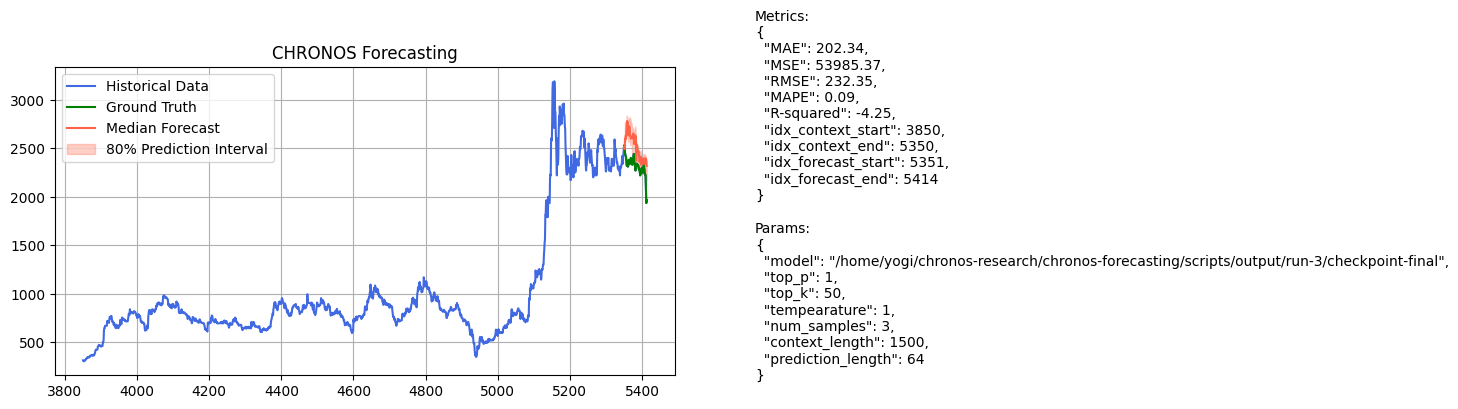

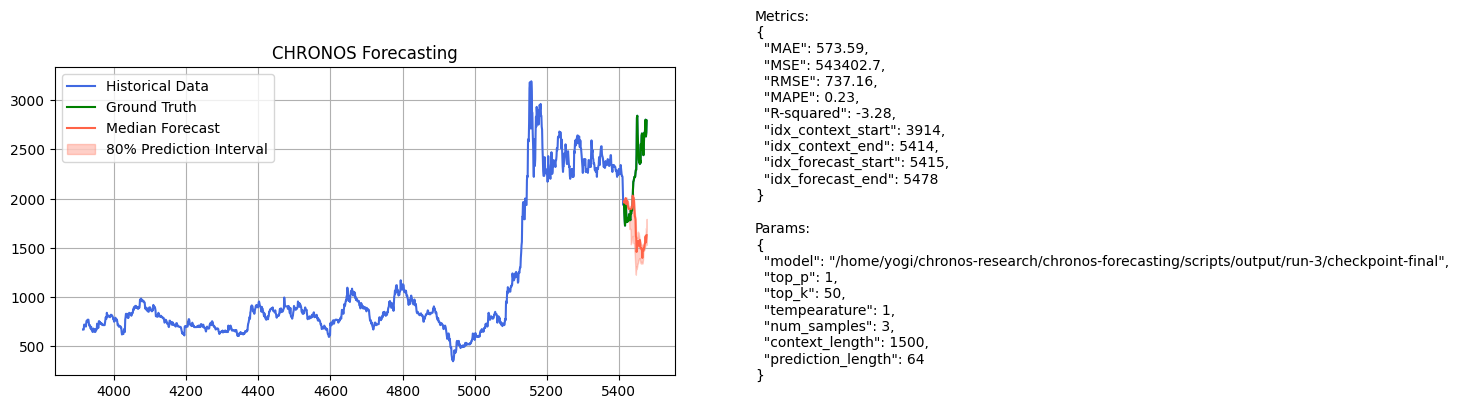

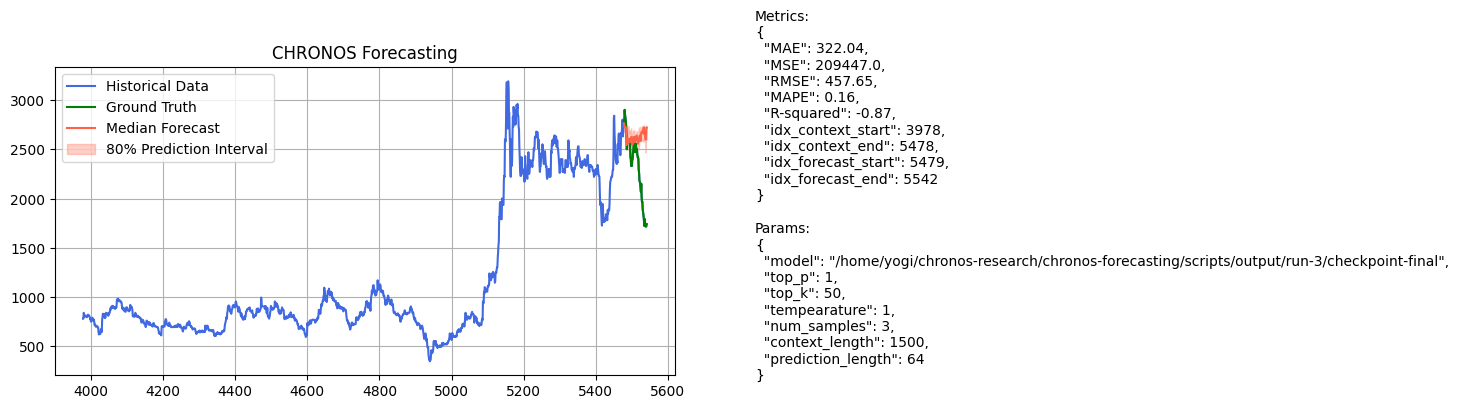

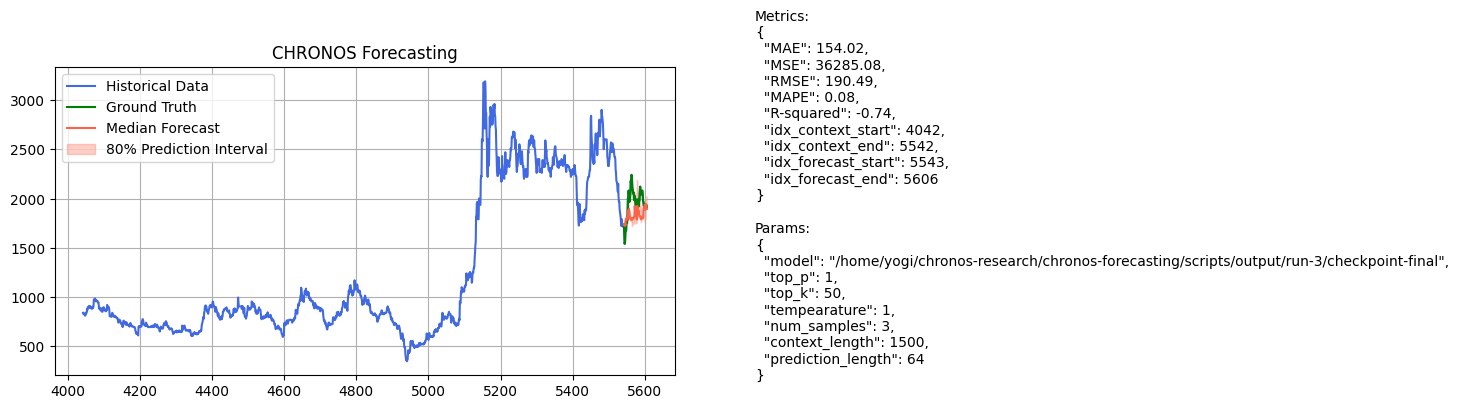

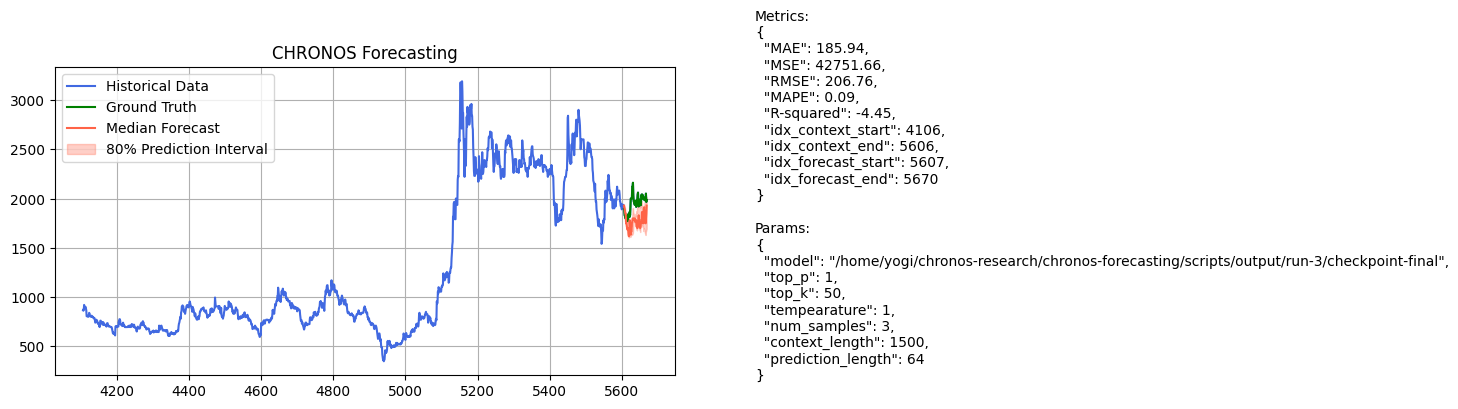

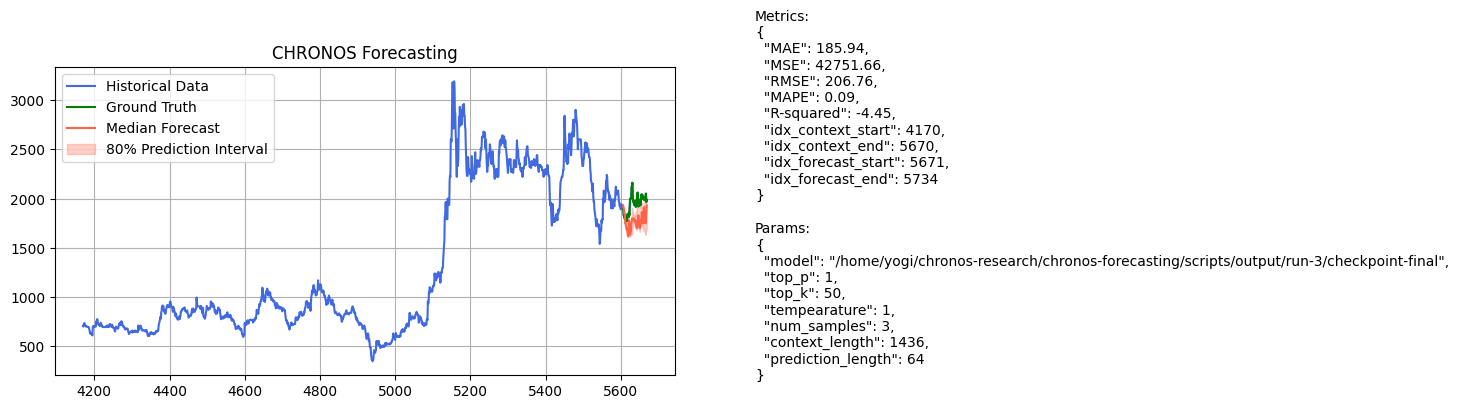

In [4]:
df = pd.read_csv('/home/yogi/chronos-research/dataset/LQ45-daily/ANTM.csv')

PRED_DURATION = 365 * 1 # A multiplier of 24 as I was working with hourly dataset
FORECAST_LEN = 64 # Trying to keep this less than 64 data points for best chronos performance
PRED_START = len(df) - PRED_DURATION # The index where to split context and test data from your df
CONTEXT_LEN = 1500 # Choose this wisely from above hyperparameter tuning experiment

agg_metrics = []
pred_indices = [i for i in range(len(df), PRED_START, -FORECAST_LEN)][::-1]


og_df = df.copy()
TARGET_COLUMN = 'close'

for idx in pred_indices:
    print(f'Running with idx = {idx}')
    fc = ChronosForecaster()
    
    df = og_df[(idx-CONTEXT_LEN):(idx+FORECAST_LEN)].copy()

    if idx > len(og_df):
        continue

    df.dropna(inplace=True)

    context, test = fc.split_train_test_by_sample_size(df, target_column=TARGET_COLUMN, test_sample_size=FORECAST_LEN)

    forecast, metrics, median = fc.predict( model_name="/home/yogi/chronos-research/chronos-forecasting/scripts/output/run-3/checkpoint-final", num_samples=3)

    metrics['idx_context_start'] = idx - CONTEXT_LEN
    metrics['idx_context_end'] = idx
    metrics['idx_forecast_start'] = idx + 1
    metrics['idx_forecast_end'] = idx + FORECAST_LEN

    agg_metrics.append(metrics | json.loads(fc.params))

    fc.plot_forecast(df[TARGET_COLUMN])

In [1]:
#%%
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from tqdm.auto import tqdm
from gluonts.dataset.common import ListDataset

from chronos import ChronosPipeline

# Load dataset
batch_size = 32
num_samples = 20
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/ANTM.csv')

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Prepare ListDataset for GluonTS
prediction_length = 64
freq = "D"  # Daily frequency
# dataset = ListDataset(
#     [{"start": df['timestamp'].iloc[0], "target": df['close'].values}],  # Assuming 'close' is the target column
#     freq=freq
# )
dataset = [
    {
        "start": pd.Period(df['timestamp'].iloc[0], freq=freq),
        "target": df["close"].values
    }
]

# Load Chronos
pipeline = ChronosPipeline.from_pretrained(
    "/home/yogi/chronos-research/chronos-forecasting/scripts/output/run-3/checkpoint-final",
    device_map="cuda:0",
    torch_dtype=torch.bfloat16,
)

# Split dataset for evaluation
train_data, test_data = split(dataset, offset=-prediction_length)
test_data = test_data.generate_instances(prediction_length)


# Generate forecast samples
forecast_samples = []
for batch in tqdm(batcher(test_data.input, batch_size=32)):
    context = [torch.tensor(entry["target"]) for entry in batch]
    forecast_samples.append(
        pipeline.predict(
            context,
            prediction_length=prediction_length,
            num_samples=num_samples,
        ).numpy()
    )
forecast_samples = np.concatenate(forecast_samples)

# Convert forecast samples into gluonts SampleForecast objects
sample_forecasts = []
for item, ts in zip(forecast_samples, test_data.input):
    forecast_start_date = ts["start"] + len(ts["target"])
    sample_forecasts.append(
        SampleForecast(samples=item, start_date=forecast_start_date)
    )

# Evaluate
metrics_df = evaluate_forecasts(
    sample_forecasts,
    test_data=test_data,
    metrics=[
        MASE(),
        MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1)),
    ],
)

metrics_df


/home/yogi/miniconda3/envs/chronos-zero-shot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
0it [00:00, ?it/s]

token=  tensor([[2115, 2114, 2114, 2114, 2114, 2114, 2116, 2117, 2117, 2118, 2118, 2125,
         2122, 2122, 2121, 2121, 2122, 2122, 2125, 2125, 2123, 2126, 2125, 2123,
         2123, 2124, 2119, 2120, 2125, 2126, 2125, 2127, 2129, 2129, 2134, 2138,
         2142, 2144, 2160, 2160, 2168, 2169, 2161, 2159, 2159, 2159, 2171, 2168,
         2167, 2167, 2167, 2183, 2186, 2185, 2208, 2208, 2207, 2219, 2240, 2244,
         2240, 2227, 2215, 2244, 2238, 2225, 2225, 2212, 2205, 2195, 2185, 2208,
         2197, 2192, 2196, 2212, 2222, 2216, 2228, 2225, 2225, 2227, 2225, 2217,
         2219, 2225, 2230, 2229, 2227, 2230, 2223, 2223, 2216, 2214, 2203, 2197,
         2189, 2186, 2186, 2186, 2197, 2192, 2188, 2190, 2189, 2187, 2187, 2188,
         2182, 2182, 2198, 2187, 2184, 2187, 2186, 2186, 2184, 2192, 2193, 2200,
         2192, 2187, 2188, 2192, 2191, 2195, 2192, 2193, 2194, 2193, 2191, 2195,
         2195, 2198, 2203, 2201, 2203, 2209, 2210, 2209, 2209, 2213, 2212, 2212,
         2212, 2212,

2024-10-25 03:57:45.486478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 03:57:45.561500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 03:57:45.581871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 03:57:45.615267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 03:57:47.328497: W tensorflow/compiler/tf2

token=  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[ 6.7383e-02,  9.8705e-05,  2.1240e-02,  ..., -2.0410e-01,
           3.9795e-02,  2.0469e+00]],

        [[ 6.7383e-02,  9.8705e-05,  2.1240e-02,  ..., -2.0410e-01,
           3.9795e-02,  2.0469e+00]],

        [[ 6.7383e-02,  9.8705e-05,  2.1240e-02,  ..., -2.0410e-01,
           3.9795e-02,  2.0469e+00]],

        ...,

        [[ 6.7383e-02,  9.8705e-05,  2.1240e-02,  ..., -2.0410e-01,
           3.9795e-02,  2.0469e+00]],

        [[ 6.7383e-02,  9.8705e-05,  2.1240e-02,  ..., -2.0410e-01,
           3.9795e-02,  2.0469e+00]],

        [[ 6.7383e-02,  9.8705e-05,  2.1240e-02,  ..., -2.0410e-01,
           3.9795e-02,  2.0469e+00]]

1it [00:07,  7.77s/it]


tensor([[[ 0.4551,  0.6016,  0.3633,  ...,  0.8945, -0.0356,  0.4297]],

        [[ 0.6680,  0.2354, -0.8359,  ..., -0.5391,  0.5312,  0.3984]],

        [[ 0.1099, -0.0674,  0.5508,  ..., -0.1177, -0.0544,  0.4219]],

        ...,

        [[ 0.3418,  0.8359,  0.5273,  ..., -0.0369,  0.6250,  0.3691]],

        [[ 0.1064,  0.8008,  0.6953,  ..., -0.2832,  0.8906,  0.3652]],

        [[ 0.3340,  0.7617, -0.5742,  ..., -0.3887,  0.0908,  0.4102]]],
       device='cuda:0', dtype=torch.bfloat16)
testt1
torch.Size([20, 1])
testt2
batch_size=  20
seq_length=  1
token=  tensor([[2156],
        [2145],
        [2167],
        [2155],
        [2146],
        [2149],
        [2156],
        [2154],
        [2167],
        [2148],
        [2161],
        [2168],
        [2163],
        [2151],
        [2149],
        [2159],
        [2164],
        [2145],
        [2147],
        [2147]], device='cuda:0')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[ 0.7578,  0.4277,  0

1it [00:00, 171.45it/s]


,MASE[0.5],mean_weighted_sum_quantile_loss
None,7.848822,0.066556


In [ ]:
#%%
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from tqdm.auto import tqdm
from gluonts.dataset.common import ListDataset

from chronos import ChronosPipeline

# Load dataset
batch_size = 32
num_samples = 20
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/ANTM.csv')

# Hitung jumlah total baris
total_rows = len(df)

# Hitung jumlah baris yang mencakup 30% terakhir
rows_to_take = int(0.3 * total_rows)

# Ambil 30% baris terakhir
df = df.tail(rows_to_take)

# # Hitung 70% dari total baris
# rows_to_take = int(0.7 * total_rows)

# # Ambil 70% pertama dari data
# df = df.head(rows_to_take)

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Prepare ListDataset for GluonTS
prediction_length = 64
freq = "D"  # Daily frequency
# dataset = ListDataset(
#     [{"start": df['timestamp'].iloc[0], "target": df['close'].values}],  # Assuming 'close' is the target column
#     freq=freq
# )
dataset = [
    {
        "start": pd.Period(df['timestamp'].iloc[0], freq=freq),
        "target": df["close"].values
    }
]

# Load Chronos
pipeline = ChronosPipeline.from_pretrained(
    "/home/yogi/chronos-research/chronos-forecasting/scripts/output/kompas100-sektor-3000/checkpoint-final",
    device_map="cuda:1",
    torch_dtype=torch.bfloat16,
)

# Split dataset for evaluation
train_data, test_data = split(dataset, offset=-prediction_length)
test_data = test_data.generate_instances(prediction_length)


# Generate forecast samples
forecast_samples = []
for batch in tqdm(batcher(test_data.input, batch_size=32)):
    context = [torch.tensor(entry["target"]) for entry in batch]
    forecast_samples.append(
        pipeline.predict(
            context,
            prediction_length=prediction_length,
            num_samples=num_samples,
        ).numpy()
    )
forecast_samples = np.concatenate(forecast_samples)

# Convert forecast samples into gluonts SampleForecast objects
sample_forecasts = []
for item, ts in zip(forecast_samples, test_data.input):
    forecast_start_date = ts["start"] + len(ts["target"])
    sample_forecasts.append(
        SampleForecast(samples=item, start_date=forecast_start_date)
    )

# Evaluate
metrics_df = evaluate_forecasts(
    sample_forecasts,
    test_data=test_data,
    metrics=[
        MASE(),
        MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1)),
    ],
)

metrics_df


0it [00:00, ?it/s]

token=  tensor([[2115, 2114, 2114, 2114, 2114, 2114, 2116, 2117, 2117, 2118, 2118, 2125,
         2122, 2122, 2121, 2121, 2122, 2122, 2125, 2125, 2123, 2126, 2125, 2123,
         2123, 2124, 2119, 2120, 2125, 2126, 2125, 2127, 2129, 2129, 2134, 2138,
         2142, 2144, 2160, 2160, 2168, 2169, 2161, 2159, 2159, 2159, 2171, 2168,
         2167, 2167, 2167, 2183, 2186, 2185, 2208, 2208, 2207, 2219, 2240, 2244,
         2240, 2227, 2215, 2244, 2238, 2225, 2225, 2212, 2205, 2195, 2185, 2208,
         2197, 2192, 2196, 2212, 2222, 2216, 2228, 2225, 2225, 2227, 2225, 2217,
         2219, 2225, 2230, 2229, 2227, 2230, 2223, 2223, 2216, 2214, 2203, 2197,
         2189, 2186, 2186, 2186, 2197, 2192, 2188, 2190, 2189, 2187, 2187, 2188,
         2182, 2182, 2198, 2187, 2184, 2187, 2186, 2186, 2184, 2192, 2193, 2200,
         2192, 2187, 2188, 2192, 2191, 2195, 2192, 2193, 2194, 2193, 2191, 2195,
         2195, 2198, 2203, 2201, 2203, 2209, 2210, 2209, 2209, 2213, 2212, 2212,
         2212, 2212,

1it [00:00,  1.80it/s]


token=  tensor([[2143],
        [2145],
        [2144],
        [2145],
        [2146],
        [2129],
        [2145],
        [2146],
        [2147],
        [2148],
        [2121],
        [2147],
        [2144],
        [2138],
        [2137],
        [2150],
        [2148],
        [2165],
        [2142],
        [2132]], device='cuda:1')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[ 0.8438,  0.6992, -0.3047,  ..., -0.1660, -0.4824,  0.2695]],

        [[ 0.6953,  0.5469,  0.4453,  ..., -0.6992,  0.5742,  0.4590]],

        [[ 0.7109,  0.7148,  0.6016,  ..., -0.4023,  0.4395,  0.4062]],

        ...,

        [[-0.0352, -0.3965,  0.0791,  ..., -0.1099,  0.1562,  0.5391]],

        [[ 0.8789,  0.7461,  0.6719,  ...,  0.2773, -0.4688,  0.2891]],

        [[ 0.2949,  1.0156,  0.3633,  ..., -0.0023, -0.2988,  0.5117]]],
       device='cuda:1', dtype=torch.bfloat16)
testt1
torch.Size([20, 1])
testt2
batch_size=  20
seq_length=  1
token=  tensor([[2143],
      

1it [00:00, 287.75it/s]


,MASE[0.5],mean_weighted_sum_quantile_loss
None,12.32141,0.15741


: 

In [2]:
#%%
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.repository import get_dataset
from gluonts.dataset.split import split
from gluonts.ev.metrics import MASE, MeanWeightedSumQuantileLoss
from gluonts.itertools import batcher
from gluonts.model.evaluation import evaluate_forecasts
from gluonts.model.forecast import SampleForecast
from tqdm.auto import tqdm
from gluonts.dataset.common import ListDataset

from chronos import ChronosPipeline

# Load dataset
batch_size = 32
num_samples = 20
df = pd.read_csv('/home/yogi/chronos-research/dataset/daily-all/AALI.csv')

# # Hitung jumlah total baris
# total_rows = len(df)

# # Hitung 70% dari total baris
# rows_to_take = int(0.7 * total_rows)

# # Ambil 70% pertama dari data
# df = df.head(rows_to_take)

# Ensure the date column is in datetime format and sort by date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Prepare ListDataset for GluonTS
prediction_length = 64
freq = "D"  # Daily frequency
# dataset = ListDataset(
#     [{"start": df['timestamp'].iloc[0], "target": df['close'].values}],  # Assuming 'close' is the target column
#     freq=freq
# )
dataset = [
    {
        "start": pd.Period(df['timestamp'].iloc[0], freq=freq),
        "target": df["close"].values
    }
]

# Load Chronos
pipeline = ChronosPipeline.from_pretrained(
    "/home/yogi/chronos-research/chronos-forecasting/scripts/output/run-5/checkpoint-final",
    device_map="cuda:0",
    torch_dtype=torch.bfloat16,
)

# Split dataset for evaluation
train_data, test_data = split(dataset, offset=-prediction_length)
test_data = test_data.generate_instances(prediction_length)


# Generate forecast samples
forecast_samples = []
for batch in tqdm(batcher(test_data.input, batch_size=32)):
    context = [torch.tensor(entry["target"]) for entry in batch]
    forecast_samples.append(
        pipeline.predict(
            context,
            prediction_length=prediction_length,
            num_samples=num_samples,
        ).numpy()
    )
forecast_samples = np.concatenate(forecast_samples)

# Convert forecast samples into gluonts SampleForecast objects
sample_forecasts = []
for item, ts in zip(forecast_samples, test_data.input):
    forecast_start_date = ts["start"] + len(ts["target"])
    sample_forecasts.append(
        SampleForecast(samples=item, start_date=forecast_start_date)
    )

# Evaluate
metrics_df = evaluate_forecasts(
    sample_forecasts,
    test_data=test_data,
    metrics=[
        MASE(),
        MeanWeightedSumQuantileLoss(np.arange(0.1, 1.0, 0.1)),
    ],
)

metrics_df


0it [00:00, ?it/s]

token=  tensor([[2189, 2190, 2194, 2194, 2194, 2194, 2190, 2192, 2190, 2193, 2194, 2192,
         2193, 2192, 2197, 2198, 2198, 2195, 2195, 2195, 2196, 2195, 2196, 2193,
         2194, 2204, 2213, 2210, 2210, 2210, 2205, 2210, 2208, 2208, 2207, 2208,
         2207, 2207, 2210, 2207, 2210, 2210, 2205, 2202, 2202, 2202, 2212, 2210,
         2213, 2213, 2213, 2223, 2222, 2219, 2222, 2222, 2218, 2215, 2213, 2214,
         2210, 2204, 2205, 2206, 2207, 2204, 2198, 2194, 2202, 2196, 2198, 2202,
         2198, 2196, 2195, 2198, 2200, 2202, 2202, 2200, 2200, 2198, 2200, 2196,
         2196, 2195, 2196, 2195, 2200, 2200, 2199, 2199, 2196, 2195, 2195, 2194,
         2198, 2197, 2196, 2196, 2200, 2201, 2198, 2196, 2196, 2194, 2193, 2194,
         2191, 2191, 2193, 2190, 2185, 2183, 2186, 2186, 2186, 2186, 2186, 2185,
         2185, 2182, 2180, 2182, 2182, 2182, 2178, 2176, 2180, 2175, 2175, 2173,
         2174, 2173, 2173, 2173, 2175, 2178, 2182, 2179, 2179, 2188, 2184, 2184,
         2184, 2184,

1it [00:01,  1.51s/it]


tensor([[[-0.0342,  0.1807,  0.1357,  ...,  0.6016,  0.7461,  0.3496]],

        [[-0.2441,  0.2852, -0.0091,  ..., -0.4785,  0.7344,  0.4043]],

        [[-0.0291,  0.6016,  0.7148,  ..., -0.4238, -0.1943,  0.3984]],

        ...,

        [[ 0.1426,  0.4922,  0.2852,  ..., -0.4648,  1.1250,  0.3730]],

        [[-0.2441,  0.2852, -0.0091,  ..., -0.4785,  0.7344,  0.4043]],

        [[-0.4492,  0.3008, -0.0879,  ..., -0.9844,  0.3809,  0.3066]]],
       device='cuda:0', dtype=torch.bfloat16)
token=  tensor([[2201],
        [2184],
        [2190],
        [2187],
        [2198],
        [2181],
        [2188],
        [2174],
        [2199],
        [2188],
        [2170],
        [2200],
        [2188],
        [2192],
        [2182],
        [2174],
        [2194],
        [2188],
        [2180],
        [2197]], device='cuda:0')
Ukuran Tabel Embedding: Embedding(4096, 512)
inputs_embeds=  tensor([[[-0.0342,  0.1807,  0.1357,  ...,  0.6016,  0.7461,  0.3496]],

        [[-0.6953, -0.

1it [00:00, 247.09it/s]


,MASE[0.5],mean_weighted_sum_quantile_loss
None,5.457479,0.112836
